# Table of Contents
 <p>

In [1]:
%load_ext autoreload
%matplotlib inline

In [100]:
%autoreload 2

import numpy as np
import dask.array as da
import matplotlib.pyplot as plt
import datetime as dt
import sys,os,glob
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LogNorm

## Add own library to path
workdir = os.getcwd()
moduledir = os.path.join(os.path.dirname(workdir),'functions')
sys.path.insert(0,moduledir)
print("Own modules available:", [os.path.splitext(os.path.basename(x))[0]
                                 for x in glob.glob(os.path.join(moduledir,'*.py'))])
## Load own libraries
from environmentAndDirectories import *
from importingData import *
from scalingApproximations import *
from slicingAndSubsetting import *

Own modules available: ['CAMsettings', 'daskOptions', 'environmentAndDirectories', 'importingData', 'physicalConstants', 'scalingApproximations', 'slicingAndSubsetting', 'statisticalDistributions', 'thermoConstants', 'thermoFunctions']


In [87]:
## Get longitude, latitude and landmask

fh = Dataset(os.path.join(inputdir_fx,'landmask_fx_CESM111-SPCAM20_allExperiments_r0i0p0.nc'))
lon1D = fh.variables['lon'][:]
lat1D = fh.variables['lat'][:]
lon2D, lat2D = np.meshgrid(lon1D,lat1D)

print("Loading lontigude, latitude and landmask")

landmask = fh.variables['landmask']


Loading lontigude, latitude and landmask


In [121]:
compset = 'FAMIPC5'
experiment = 'piControl'
subset = 'tropics'
time_stride = 'day'

historyFilesSettings = getCAMHistoryFilesSettings()

inputdir, inputdir_processed_day, inputdir_processed_1hr, inputdir_results, inputdir_fx = \
    getInputDirectories(compset,experiment)

daskarray = True
    
q_id = 'Q'
spechum = getValues(q_id,compset,subset,experiment,time_stride,daskarray=daskarray)
omega_id = 'OMEGA'
omega = getValues(omega_id,compset,subset,experiment,time_stride,daskarray=daskarray)
pr_id = 'PRECT'
pr = getValues(pr_id,compset,subset,experiment,time_stride,daskarray=daskarray)
ts_id = 'TS'
ts = getValues(ts_id,compset,subset,experiment,time_stride,daskarray=daskarray)

Q found in history files
Importing Q from 25 files
  from
  /Users/bfildier/Data/simulations/bf_FAMIPC5_piControl/bf_FAMIPC5_piControl.cam.h0.1850-05-01-00000.nc
  to
  /Users/bfildier/Data/simulations/bf_FAMIPC5_piControl/bf_FAMIPC5_piControl.cam.h0.1850-05-02-00000.nc
OMEGA found in history files
Importing OMEGA from 25 files
  from
  /Users/bfildier/Data/simulations/bf_FAMIPC5_piControl/bf_FAMIPC5_piControl.cam.h0.1850-05-01-00000.nc
  to
  /Users/bfildier/Data/simulations/bf_FAMIPC5_piControl/bf_FAMIPC5_piControl.cam.h0.1850-05-02-00000.nc
PRECT found in history files
Importing PRECT from 25 files
  from
  /Users/bfildier/Data/simulations/bf_FAMIPC5_piControl/bf_FAMIPC5_piControl.cam.h0.1850-05-01-00000.nc
  to
  /Users/bfildier/Data/simulations/bf_FAMIPC5_piControl/bf_FAMIPC5_piControl.cam.h0.1850-05-02-00000.nc
TS found in history files
Importing TS from 25 files
  from
  /Users/bfildier/Data/simulations/bf_FAMIPC5_piControl/bf_FAMIPC5_piControl.cam.h0.1850-05-01-00000.nc
  to
  

In [106]:
print(pr.shape)

(4, 32, 144)


In [4]:
input_lev_file = os.path.join(inputdir_fx,'lev_fx_CESM111-SPCAM20_allExperiments_r0i0p0.nc')
computeP = getPressureCoordinateFunction(input_lev_file)

In [76]:
ps_varid = 'PS'
ps = getValues(ps_varid,compset,subset,experiment,time_stride,daskarray=daskarray)
pres = computeP(ps)

PS found in history files
Importing PS from 25 files
  from
  /Users/bfildier/Data/simulations/bf_FAMIPC5_piControl/bf_FAMIPC5_piControl.cam.h0.1850-05-01-00000.nc
  to
  /Users/bfildier/Data/simulations/bf_FAMIPC5_piControl/bf_FAMIPC5_piControl.cam.h0.1850-05-02-00000.nc


In [147]:
p_500 = 500; levdim=1
p_925 = 925
omega_500 = isobaricSurface(omega,pres,p_ref=p_500,levdim=levdim)
spechum_925 = isobaricSurface(spechum,pres,p_ref=p_925,levdim=levdim)
p_sc1 = singleLevelScalingFromOmegaQ(spechum_925,-omega_500)

In [148]:
p_sc2 = singleLevelScalingFromOmegaT(-omega_500,ts,ps)

In [98]:
log10(np.nanmin(v[v > 0]))

/Users/bfildier/anaconda/envs/py36/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


-7.237368145630476

In [144]:
def plotMap(lon2D,lat2D,v,above_zero=False,v_min=None,v_max=None,mode=None):
    
    if v_min is None:
        if above_zero:
            v_min = np.nanmin(v[v > 0])
        else:
            v_min = np.nanmin(v)
    if v_max is None:
        v_max = np.nanmax(v)

    nlev = 10
    fig = plt.figure(figsize=(12,2))
    map = Basemap(projection='cyl',lat_0=0,lon_0=180,llcrnrlon=0,llcrnrlat=-30,urcrnrlon=357,urcrnrlat=30)
    if mode == "log":
        levs = np.logspace(log10(v_min),log10(v_max),nlev)
        norm = LogNorm()
    else:
        levs = np.linspace(v_min,v_max,nlev)
        norm = None
    map.contourf(lon2D,lat2D,v,levels=levs,cmap=plt.cm.Greens,norm = norm)    
    #         map.contourf(lon2D,lat2D,freqMap,cmap=plt.cm.Greens)
    map.drawparallels(range(-90, 100, 30),labels=[1,0,0,1])
    map.drawmeridians(range(0,400,90),labels=[1,0,0,1])
    map.drawcoastlines()
    # if subset == 'ocean':
    #     map.fillcontinents(color='k')

    # plt.title('Frequency of extreme %s in %s'%(pr_labels_veryshort[pr_id],compset_labels[compset]))
    plt.colorbar(ticks=levs,pad=0.02,fraction=0.085)

/Users/bfildier/anaconda/envs/py36/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3630: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/bfildier/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/contour.py:1518: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')
/Users/bfildier/anaconda/envs/py36/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3699: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


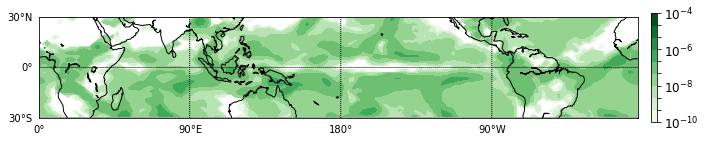

In [137]:
## Plot

v = pr[0,...]

plotMap(lon2D,lat2D,v,v_min=1e-10,v_max=1e-4,mode='log')

plt.show()

/Users/bfildier/anaconda/envs/py36/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3630: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/bfildier/anaconda/envs/py36/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3699: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


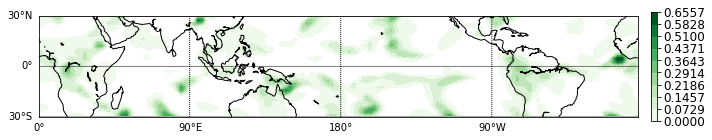

In [152]:
## Plot

v = -omega_500[0,...]

plotMap(lon2D,lat2D,v,above_zero=True)

plt.show()

/Users/bfildier/anaconda/envs/py36/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/Users/bfildier/anaconda/envs/py36/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3630: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/bfildier/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/contour.py:1517: RuntimeWarning: invalid value encountered in less_equal
  z = ma.masked_where(z <= 0, z)
/Users/bfildier/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/contour.py:1518: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')
/Users/bfildier/anaconda/envs/py36/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3699: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more d

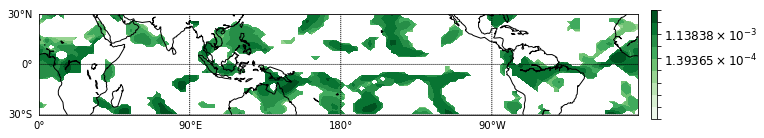

In [153]:
## Plot

v = p_sc1[0,...]

v_max = np.nanmax(v)

plotMap(lon2D,lat2D,v,above_zero=True,mode='log')

# plt.savefig(os.path.join(figdir,"fig_frequencyMap_%s_%s_%s_%s_%s.pdf"%(pr_id,Q_id,compset,experiment,subset)),
#     bbox_inches='tight')
plt.show()

57558.6 102739.0


/Users/bfildier/anaconda/envs/py36/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3630: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/bfildier/anaconda/envs/py36/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3699: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


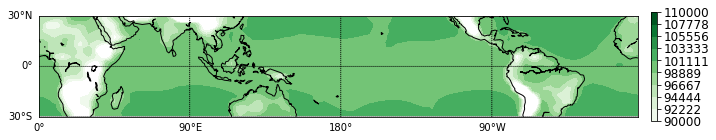

In [142]:
## Plot

# v = pr[0,...]
v = ps[0,...]

print(v.min().compute(),v.max().compute())

plotMap(lon2D,lat2D,v,v_min=90000,v_max=110000)

# plt.savefig(os.path.join(figdir,"fig_frequencyMap_%s_%s_%s_%s_%s.pdf"%(pr_id,Q_id,compset,experiment,subset)),
#     bbox_inches='tight')
plt.show()

/Users/bfildier/anaconda/envs/py36/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3630: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/bfildier/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/contour.py:1518: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')
/Users/bfildier/anaconda/envs/py36/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3699: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


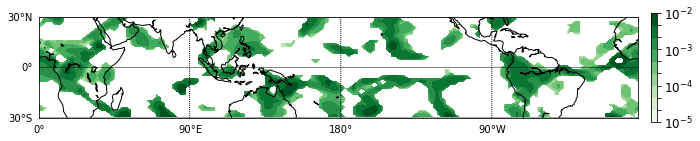

In [154]:
## Plot

# v = pr[0,...]
v = p_sc2[0,...]

plotMap(lon2D,lat2D,v,above_zero=True,v_min=1e-5,v_max=1e-2,mode='log')

plt.show()